In [1]:
import numpy as np
import os
import io
import cv2
import glob
import tensorflow as tf
from densenet import densenet_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Disable GPU
# tf.config.experimental.set_visible_devices([], 'GPU')
# tf.config.experimental.list_logical_devices('GPU')

[]

In [3]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
print(tf.config.experimental.list_logical_devices('GPU'))
tf.test.is_gpu_available()


'\ngpus = tf.config.experimental.list_physical_devices(\'GPU\')\nif gpus:\n    try:\n        # Currently, memory growth needs to be the same across GPUs\n        for gpu in gpus:\n              tf.config.experimental.set_memory_growth(gpu, True)\n        logical_gpus = tf.config.experimental.list_logical_devices(\'GPU\')\n        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")\n    except RuntimeError as e:\n        # Memory growth must be set before GPUs have been initialized\n        print(e)\n        \nprint(tf.config.experimental.list_logical_devices(\'GPU\'))\ntf.test.is_gpu_available()\n'

In [4]:
# hyperparameters
# data
rotation_range = 20
width_shift_range = 0.2
height_shift_range = 0.2
horizontal_flip = True
vertical_flip = True
shear_range = 0
zoom_range = 0.5
size = (512,512)

# model
nb_filter = 64
growth_rate = 16
nb_layers = [6, 12, 24, 16]
reduction = 0.5

# training
lr = 0.01
epochs = 200
max_patience = 50
batch_size = 2

# log
log_freq = 1
models_directory = 'results/models/'
date = datetime.now().strftime("%Y_%m_%d-%H:%M:%S")
identifier = "{}-growth-{}-densenet".format(
    '-'.join([str(i) for i in nb_layers]),
    growth_rate) + date

In [5]:
origin_dir = '../../data/best-artworks-of-all-time/'
images_dir = origin_dir + 'images/'
x = []
y = []
i = 0
for artist in os.listdir(images_dir):
    for filename in glob.glob(images_dir + artist +'/*.jpg'):
        x.append(filename)
        y.append(i)
    i += 1
n_classes = len(np.unique(y))

In [6]:
# for a new value newValue, compute the new count, new mean, the new M2.
# mean accumulates the mean of the entire dataset
# M2 aggregates the squared distance from the mean
# count aggregates the number of samples seen so far
def update(existingAggregate, newValue):
    (count, mean, M2) = existingAggregate
    count += 1 
    delta = newValue - mean
    mean += delta / count
    delta2 = newValue - mean
    M2 += delta * delta2

    return (count, mean, M2)

# retrieve the mean, variance and sample variance from an aggregate
def finalize(existingAggregate):
    (count, mean, M2) = existingAggregate
    (mean, variance, sampleVariance) = (mean, M2/count, M2/(count - 1)) 
    if count < 2:
        return float('nan')
    else:
        return (mean, variance, sampleVariance)

size = (512,512)
 
existingAggregate = (0, np.zeros((512,512,3), dtype=np.float64), np.zeros((512,512,3), dtype=np.float64))
for i in range(len(x)):
    existingAggregate = update(existingAggregate, cv2.resize(cv2.imread(x[i]), size)/255.)
    if (i > 0 and i % 800 == 0):
        print('van 1000')
mean, variance, sampleVariance = finalize(existingAggregate)

van 1000
van 1000
van 1000
van 1000
van 1000
van 1000
van 1000
van 1000
van 1000
van 1000
van 1000


In [7]:
classes = np.unique(y)
n_classes = len(classes)
class_weights = compute_class_weight('balanced', 
                                     classes,
                                     y)
y = tf.keras.utils.to_categorical(y)

In [8]:
class_weights

array([1.9688172 , 0.54494048, 1.11646341, 1.36641791, 1.67981651,
       0.69885496, 0.97393617, 1.86836735, 0.76610879, 2.12906977,
       1.30785714, 2.54305556, 1.94787234, 0.62920962, 1.84949495,
       0.55823171, 1.4531746 , 0.71803922, 1.66454545, 0.94870466,
       1.30785714, 2.26049383, 1.56495726, 1.07076023, 0.94381443,
       0.70694981, 1.53865546, 1.79509804, 1.38712121, 0.41708428,
       1.33649635, 1.55169492, 1.25410959, 0.26082621, 1.31726619,
       1.36641791, 0.20877993, 1.43046875, 1.28041958, 2.1045977 ,
       2.08068182, 2.1797619 , 1.01160221, 0.58874598, 1.52583333,
       2.03444444, 0.9844086 , 1.29858156, 2.01208791, 2.26049383])

In [9]:
datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    horizontal_flip=horizontal_flip,
    vertical_flip = vertical_flip,
    shear_range=shear_range,
    zoom_range=zoom_range,
    fill_mode='constant',
    cval=0)

test_datagen = ImageDataGenerator(rescale=1./255.)

In [10]:
img_shape = cv2.resize(cv2.imread(x[0]), size).shape
model = densenet_model(classes=n_classes, nb_filter=nb_filter, shape=img_shape, growth_rate=growth_rate, nb_layers=nb_layers, reduction=reduction)
'''
img_input = Input(shape=img_shape, name='data')
base_model = tf.keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=img_shape)
base_model.trainable = False
x = base_model(img_input)
x = BatchNormalization(name='conv_final_blk_bn')(x)
x = Activation('relu', name='relu_final_blk')(x)
x = GlobalAveragePooling2D(name='pool_final')(x)
x = Dense(n_classes, name='fc6')(x)
output = Activation('softmax', name='prob')(x)
model = Model(inputs=img_input, outputs=output)
'''

"\nimg_input = Input(shape=img_shape, name='data')\nbase_model = tf.keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=img_shape)\nbase_model.trainable = False\nx = base_model(img_input)\nx = BatchNormalization(name='conv_final_blk_bn')(x)\nx = Activation('relu', name='relu_final_blk')(x)\nx = GlobalAveragePooling2D(name='pool_final')(x)\nx = Dense(n_classes, name='fc6')(x)\noutput = Activation('softmax', name='prob')(x)\nmodel = Model(inputs=img_input, outputs=output)\n"

In [11]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def weightedLoss(originalLossFunc, weightsList):

    @tf.function
    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first

        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = tf.argmax(true, axis=axis, output_type=tf.int32) 

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [tf.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [tf.cast(x, tf.float32) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc
loss_object = weightedLoss(loss_object, class_weights)

optimizer = tf.keras.optimizers.Adam()

In [12]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [13]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(tf.cast(images, tf.float32), training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

    return predictions

In [14]:
@tf.function
def test_step(images, labels):
    predictions = model(tf.cast(images, tf.float32), training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    
    return predictions

In [15]:
train_size = 0
for artist in os.listdir(origin_dir + 'train/'):
    train_size += len(glob.glob(origin_dir + 'train/' + artist +'/*.jpg'))
        
test_size = 0
for artist in os.listdir(origin_dir + 'test/'):
    test_size += len(glob.glob(origin_dir + 'test/' + artist +'/*.jpg'))

In [16]:
# create summary writers
train_summary_writer = tf.summary.create_file_writer('results/summaries/train/' + identifier)
test_summary_writer = tf.summary.create_file_writer('results/summaries/test/' + identifier)

# create data generators
train_gen =  datagen.flow_from_directory(origin_dir + 'train/', target_size=size, batch_size=batch_size)
test_gen = test_datagen.flow_from_directory(origin_dir + 'test/', target_size=size, batch_size=batch_size, shuffle=False)

min_loss = 100
min_loss_acc = 0
patience = 0

Found 7465 images belonging to 50 classes.
Found 1690 images belonging to 50 classes.


W0830 01:41:09.364110 140673916643136 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


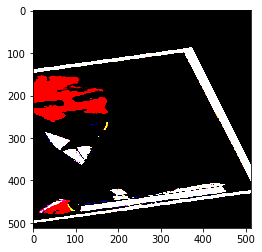

In [17]:
for images, labels in train_gen:
    plt.imshow((images[0] - mean) / variance)
    print(labels[0])
    break

In [18]:
print("starting training")
time_record = ''
for epoch in range(epochs):
    time_start = time.time()
    batches = 0
    for images, labels in train_gen:
        images = (images - mean) / variance
        train_step(images, labels)
        batches += 1
        if batches >= train_size / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

    batches = 0
    all_predictions = np.array([]).reshape(0, n_classes)
    all_labels = np.array([]).reshape(0, n_classes)
    for test_images, test_labels in test_gen:
        test_images = (test_images - mean) / variance
        all_predictions = np.vstack((all_predictions, test_step(test_images, test_labels))) 
        all_labels = np.vstack((all_labels, test_labels))
        batches += 1
        if batches >= test_size / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
    time_finish = time.time()
    end_time = (time_finish-time_start)
    time_record = time_record + '{:.3f} s \n'.format(end_time)

    if (epoch % log_freq == 0):
        print ('Epoch: {}, Train Loss: {}, Train Acc:{}, Test Loss: {}, Test Acc: {}, Time: {} s'.format(
               epoch,
               train_loss.result(),
               train_accuracy.result()*100,
               test_loss.result(),
               test_accuracy.result()*100,
               end_time))

        if (test_loss.result() < min_loss):    
            if not os.path.exists(models_directory):
                os.makedirs(models_directory)
            # serialize weights to HDF5
            model.save_weights(models_directory + "best{}.h5".format(identifier))
            min_loss = test_loss.result()
            min_loss_acc = test_accuracy.result()
            patience = 0
        else:
            patience += 1

        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
            #tf.summary.image('Confusion Matrix', image, step=epoch)
            train_loss.reset_states()           
            train_accuracy.reset_states()           

        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
            test_loss.reset_states()           
            test_accuracy.reset_states()   
            # save confusion matrix
            con_mat = tf.math.confusion_matrix(
                labels=np.argmax(all_labels, axis=1), 
                predictions=np.argmax(all_predictions, axis=1),
                num_classes=n_classes).numpy()
            con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
            con_mat_df = pd.DataFrame(con_mat_norm,
                                 index = classes, 
                                 columns = classes)
            figure = plt.figure(figsize=(8, 8))
            sns.heatmap(con_mat_df, annot=False,cmap=plt.cm.Blues)
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            plt.close(figure)
            buf.seek(0)
            image = tf.image.decode_png(buf.getvalue(), channels=4)
            image = tf.expand_dims(image, 0)
            tf.summary.image('Confusion Matrix', image, step=epoch)

    if patience >= max_patience:
        break

with open(os.path.join('results/', identifier), "w") as file1:
    file1.write(time_record)

starting training


W0830 01:41:13.952956 140673916643136 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 0, Train Loss: 4.963510513305664, Train Acc:9.162759780883789, Test Loss: 4.776061534881592, Test Acc: 11.893491744995117, Time: 7605.044733285904 s


E0830 04:08:19.302898 140673916643136 ultratb.py:149] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-2c4d58db66cd>", line 8, in <module>
    train_step(images, labels)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 404, in __call__
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/function.py", line 1335, in __call__
    return graph_function._filtered_call(args, kwargs)  # pylint: disable=protected-access
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/function.py", line 589, in _filtered_call
    (t for t in nest.flatten((args, kwargs), expand_composites=True)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/function.py", line 671, in _call_flat
    outputs = self._inference_funct

KeyboardInterrupt: 